# HR Data Classification

## Project Card

- 개요 : IBM HR Data를 활용하여 사원의 퇴사 여부를 예측한다.
- 데이터 :
    - 설명 : IBM사 직우너들의 profile
    - 데이터 수 : 1470
    - feature 수 : 35
- 프로젝트 목적
    - 직원 profile 데이터를 활용해 특정 직원이 퇴사할 지 여부를 판단
    - 이를 통해 업무 공백 없이 업무 효율을 높이고자 함
- 프로세스
    1. 분석 목표 정의
        - 데이터 확인
        - 분석 문제점 정의
    2. EDA
        - Data Summary
        - Data Expolore
        - Insight
    3. Data Preprocessing
        - Missing Value
        - EDA
        - Statistic Test
        - Encoding
        - Feature Transformation
        - Sampling
    4. ML Analysis
        - Base Model
        - Model Optimization
        - Model Evaluation
        - Model Analysis

## Import & Settings

In [2]:
# Feature Engineering, EDA
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import (
    Axes3D,
    proj3d
)
from datetime import datetime

# statistic
from scipy import stats
from scipy.stats import (
    chi2_contingency,
    kruskal
)
from statsmodels.stats.outliers_influence import variance_inflation_factor

# sampling
from imblearn.combine import SMOTEENN

# ml
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
from xgboost import (
    XGBClassifier,
    plot_importance
)

In [4]:
CONFIG = {
    'random_seed' : 42
}

## Data Load

In [3]:
data = pd.read_csv(os.path.join(os.getcwd(), 'data', 'ml_project_lab', 'HR-Employee-Attrition.csv'))

data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


## Data EDA / PreProcessing

### Feature 이름 확인

In [9]:
features = data.columns

print(features)

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked',
       'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating',
       'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance',
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')


### Duplicated Samples 확인

중복 데이터가 존재하면, 다음을 검토
1. 머신러닝 데이터를 만드는, 데이터 준비 과정에서 문제가 없었는가?
2. 수집 시스템 자체에 문제가 없는가?

In [10]:
print(f"Number of Duplicated Samples : {len(data[data.duplicated()])}")

Number of Duplicated Samples : 0


### Data Type & Summary

```
- Categorical Features : 19 (include TARGET)
- Numerical Features : 16
- Duplicated Samples : 0
```

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [16]:
# Check Categorical / Numerical Feature
for feature in features:
    print(
        f"[ '{feature}' ]",
        f"\n- Data Type : {data[feature].dtype}",
        f"\n- Unique Values : \n {data[feature].unique()}\n"
    )

[ 'Age' ] 
- Data Type : int64 
- Unique Values : 
 [41 49 37 33 27 32 59 30 38 36 35 29 31 34 28 22 53 24 21 42 44 46 39 43
 50 26 48 55 45 56 23 51 40 54 58 20 25 19 57 52 47 18 60]

[ 'Attrition' ] 
- Data Type : object 
- Unique Values : 
 ['Yes' 'No']

[ 'BusinessTravel' ] 
- Data Type : object 
- Unique Values : 
 ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']

[ 'DailyRate' ] 
- Data Type : int64 
- Unique Values : 
 [1102  279 1373 1392  591 1005 1324 1358  216 1299  809  153  670 1346
  103 1389  334 1123 1219  371  673 1218  419  391  699 1282 1125  691
  477  705  924 1459  125  895  813 1273  869  890  852 1141  464 1240
 1357  994  721 1360 1065  408 1211 1229  626 1434 1488 1097 1443  515
  853 1142  655 1115  427  653  989 1435 1223  836 1195 1339  664  318
 1225 1328 1082  548  132  746  776  193  397  945 1214  111  573 1153
 1400  541  432  288  669  530  632 1334  638 1093 1217 1353  120  682
  489  807  827  871  665 1040 1420  240 1280  534 1456  658  142 1127


> Categorical Feature
>> 'Attrition', 'BusinessTravel', 'Department', 'Education', 'EducationField', 'EmployeeNumber', 'EnvironmentStatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole',
'JobSatisfaction', 'MaritalStatus', 'Over18', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'

In [23]:
cat_features = [
    'Attrition', 'BusinessTravel', 'Department', 'Education', 'EducationField', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole',
    'JobSatisfaction', 'MaritalStatus', 'Over18', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance'
]
num_features = [feature for feature in features if feature not in cat_features]
TARGET_FEATURE = 'Attrition'

In [24]:
for feature in features:
    if feature in cat_features:
        data[feature] = data[feature].astype('object')
    else:
        data[feature] = data[feature].astype('int64')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   object
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   object
 10  EnvironmentSatisfaction   1470 non-null   object
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   object
 14  JobLevel                

### Dependent Feature Explore

> Imbalance Data 임을 확인함
1. 2 target class의 비중 차이가 큼
    - 독립 변수에 categorical feature가 포함된 경우 one-hot encoding을 수행한 뒤 sampling 수행해야 함
2. 소수 class ("Yes")인 Sample들이 유의미한 데이터 분포와 특성을 가진다면, 추가적인 sampling 없이도 충분히 모델 학습이 될 가능성 존재
3. ML 학습 시 cost-sensitive (class weight 등)을 활용할 수 있음

```
1. 데이터 기반 접근 방식
- Sampling (over / under / combine)
```

```
2. ML 알고리즘 기반 접근 방법
- ML 학습 시 class weight 활용해 cost-sensitive learning
```

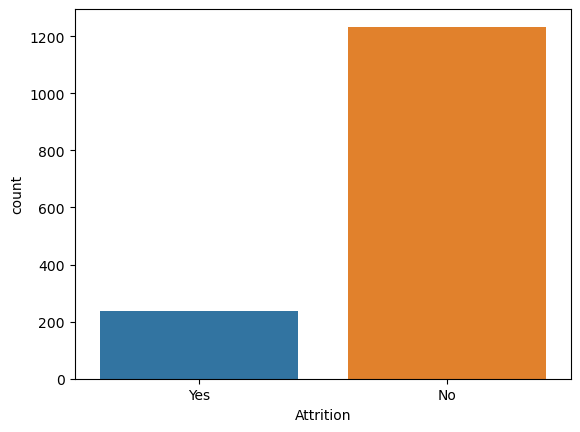

In [26]:
sns.countplot(data=data, x=TARGET_FEATURE, hue=TARGET_FEATURE)
plt.show()

### Independent Feature Explore

#### Categorical Feature

In [27]:
idp_cat_features = [feat for feat in cat_features if feat != TARGET_FEATURE]

##### 불필요 Feature 확인

In [ ]:
# 불필요 feature 제거
data[idp_cat_features].nunique().sort_values(ascending=True)

Over18                         1
PerformanceRating              2
OverTime                       2
Gender                         2
BusinessTravel                 3
Department                     3
MaritalStatus                  3
RelationshipSatisfaction       4
JobSatisfaction                4
WorkLifeBalance                4
StockOptionLevel               4
JobInvolvement                 4
EnvironmentSatisfaction        4
Education                      5
JobLevel                       5
EducationField                 6
JobRole                        9
EmployeeNumber              1470
dtype: int64

In [31]:
# Over18 -> feature value가 1개이므로 무의미한 feature
# EmployeeNumber -> 고유 ID 이므로 제거
data = data.drop(['Over18', 'EmployeeNumber'], axis=1)

idp_cat_features.remove("Over18")
idp_cat_features.remove("EmployeeNumber")

In [32]:
len(idp_cat_features)

16

##### feature 별 분포 확인

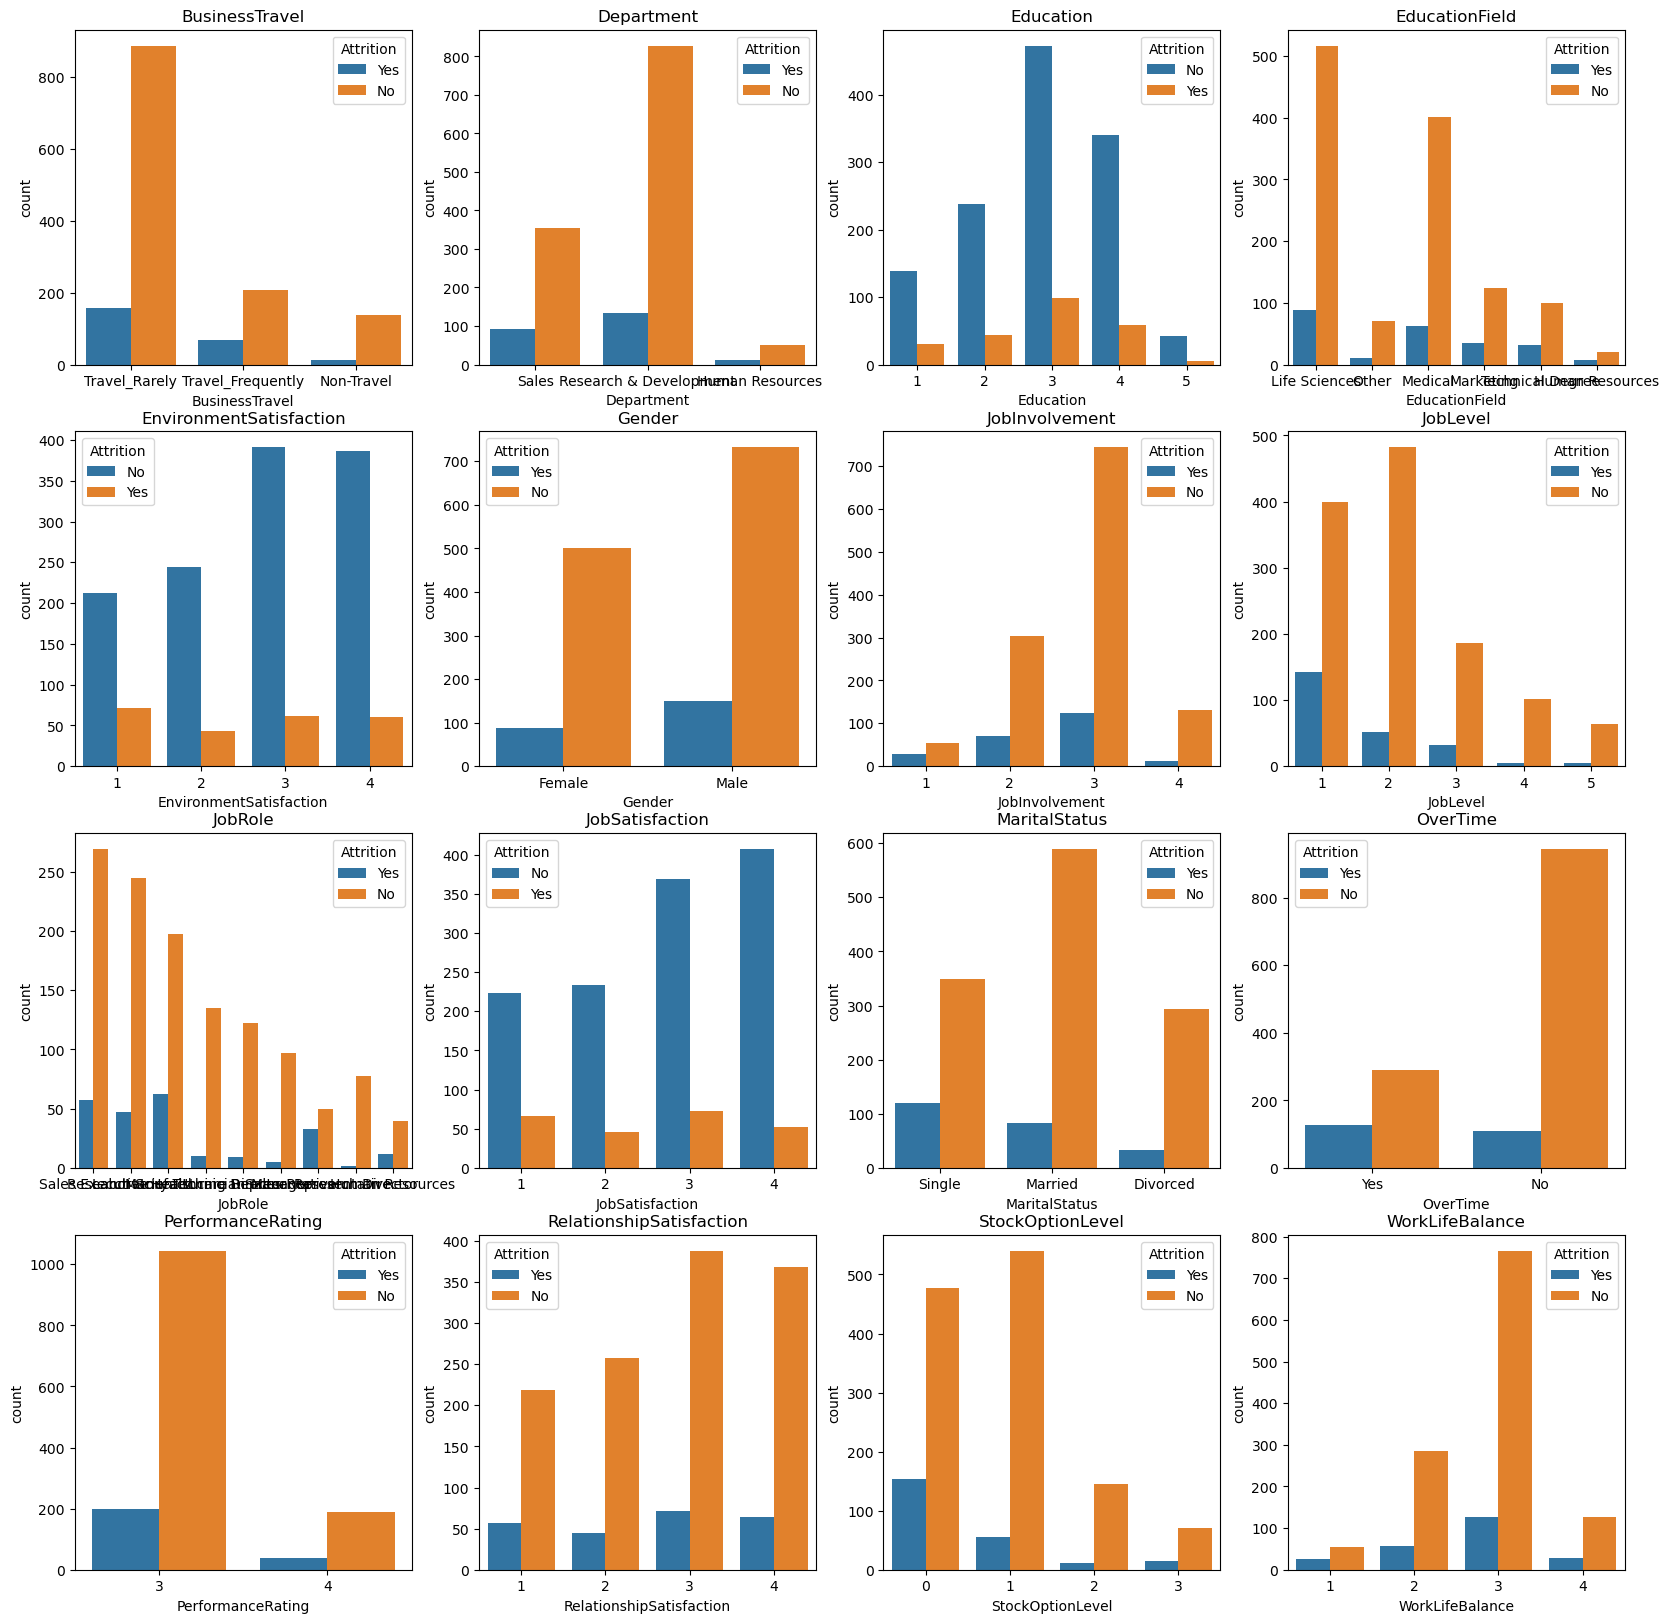

In [ ]:
fig = plt.figure(figsize=(20,20))
x = 1
for feature in idp_cat_features:
    fig.add_subplot(4,4,x)
    x += 1
    sns.countplot(data=data, x=feature, hue=TARGET_FEATURE)
    plt.xticks()
    plt.title(f"{feature}")
plt.show()